In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import platform
import random
import string
import uuid
import math
import os
import os.path
import skimage
import sak
import sak.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import networkx
import networkx.algorithms.approximation
import wfdb
import json
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from sak.signal import StandardHeader

import src.data

# Data loader to un-clutter code    
def load_data(filepath):
    dic = dict()
    with open(filepath) as f:
        text = list(f)
    for line in text:
        line = line.replace(' ','').replace('\n','').replace(',,','')
        if line[-1] == ',': line = line[:-1]
        head = line.split(',')[0]
        tail = line.split(',')[1:]
        if tail == ['']:
            tail = np.asarray([])
        else:
            tail = np.asarray(tail).astype(int)

        dic[head] = tail
    return dic


def trailonset(sig,on):
    on = on-sig[0]
    off = on-sig[0]+sig[-1]
    sig = sig+np.linspace(on,off,sig.size)
    
    return sig

def getcorr(segments):
    if len(segments) > 0:
        length = 2*max([seg.size for seg in segments])
    else:
        return np.zeros((0,0))

    corr = np.zeros((len(segments),len(segments)))

    for i,seg1 in enumerate(segments):
        for j,seg2 in enumerate(segments):
            if i != j:
                if seg1.size != seg2.size:
                    if seg1.size != 1:
                        x1 = sp.interpolate.interp1d(np.linspace(0,1,len(seg1)),seg1)(np.linspace(0,1,length))
                    else:
                        x1 = np.full((length,),seg1[0])
                    if seg2.size != 1:
                        x2 = sp.interpolate.interp1d(np.linspace(0,1,len(seg2)),seg2)(np.linspace(0,1,length))
                    else:
                        x2 = np.full((length,),seg2[0])
                else:
                    x1 = seg1
                    x2 = seg2
                if (x1.size == 1) and (x2.size == 1):
                    corr[i,j] = 1
                else:
                    c,_ = sak.signal.xcorr(x1,x2)
                    corr[i,j] = np.max(np.abs(c))
            else:
                corr[i,j] = 1
                
    return corr

def order_fiducials(qrs, other, mode='smaller'):
    # just in case
    other = np.copy(other)

    if mode=='smaller':
        filt = (other[None,:] < qrs[:,None])
    elif mode=='bigger':
        filt = (qrs[:,None] < other[None,:])
    else:
        raise ValueError("Mode must be {smaller, bigger}")
        
    if other.size == 0:
        return np.full_like(qrs,-1,dtype=int)
        
    for i in range(qrs.size):
        if i >= filt.shape[1]:
            newcol = np.zeros((qrs.size,),dtype=bool)
            if mode=='smaller':
                newcol[i:] = True
            elif mode=='bigger':
                newcol[:i+1] = True
            other = np.insert(other,i,-1)
            filt = np.insert(filt,i,newcol,axis=1)
        else:
            if mode=='smaller':
                j = np.nonzero(filt[:,i])[0][0]
            elif mode=='bigger':
                j = qrs.size-np.nonzero(np.flip(filt[:,i]))[0][0]-1

            if i != j:
                newcol = np.zeros((qrs.size,),dtype=bool)
                if mode=='smaller':
                    newcol[i:] = True
                elif mode=='bigger':
                    newcol[:i+1] = True
                other = np.insert(other,i,-1)
                filt = np.insert(filt,i,newcol,axis=1)

    return other

In [3]:
basedir = '/media/guille/DADES/DADES/Delineator'

In [4]:
#### LOAD DATASETS ####
dataset             = pd.read_csv(os.path.join(basedir,'QTDB','Dataset.csv'), index_col=0)
dataset             = dataset.sort_index(axis=1)
labels              = np.asarray(list(dataset)) # In case no data augmentation is applied
description         = dataset.describe()
group               = {k: '_'.join(k.split('_')[:-1]) for k in dataset}
unique_ids          = list(set([k.split('_')[0] for k in dataset]))

# Load validity
validity            = sak.load_data(os.path.join(basedir,'QTDB','validity.csv'))

# Load fiducials
Pon_QTDB            = load_data(os.path.join(basedir,'QTDB','PonNew.csv'))
Poff_QTDB           = load_data(os.path.join(basedir,'QTDB','PoffNew.csv'))
QRSon_QTDB          = load_data(os.path.join(basedir,'QTDB','QRSonNew.csv'))
QRSoff_QTDB         = load_data(os.path.join(basedir,'QTDB','QRSoffNew.csv'))
Ton_QTDB            = load_data(os.path.join(basedir,'QTDB','TonNew.csv'))
Toff_QTDB           = load_data(os.path.join(basedir,'QTDB','ToffNew.csv'))

In [5]:
# Generate masks & signals
x = {}
y = {}
for k in tqdm.tqdm(QRSon_QTDB):
    # Check file exists and all that
    if k not in validity:
        print("Issue with file {}, continuing...".format(k))
        continue

    # Store signal
    signal = dataset[k][validity[k][0]:validity[k][1]].values
    signal = sak.signal.on_off_correction(signal)
    amplitude = np.median(sak.signal.moving_lambda(signal,200,sak.signal.abs_max))
    signal = signal/amplitude
    x[k] = signal[None,]
    
    # Generate boolean mask
    segmentation = np.zeros((3,dataset.shape[0]),dtype=bool)
    if k in Pon_QTDB:
        for on,off in zip(Pon_QTDB[k],Poff_QTDB[k]):
            segmentation[0,on:off] = True
    if k in QRSon_QTDB:
        for on,off in zip(QRSon_QTDB[k],QRSoff_QTDB[k]):
            segmentation[1,on:off] = True
    if k in Ton_QTDB:
        for on,off in zip(Ton_QTDB[k],Toff_QTDB[k]):
            segmentation[2,on:off] = True
    
    y[k] = segmentation[:,validity[k][0]:validity[k][1]]
    

100%|██████████| 206/206 [00:00<00:00, 1789.96it/s]

Issue with file sel35_0, continuing...
Issue with file sel35_1, continuing...


In [6]:
x2 = {''.join(np.random.choice(list(string.ascii_letters),size=np.random.randint(5,10))): np.random.rand(1,2048) for i in range(210)}
y2 = {k: np.random.rand(3,np.random.randint(3800,10872)) > 0.7 for k in x2}

dataset1 = src.data.DatasetQTDB( x, y,2048,128)
dataset2 = src.data.DatasetQTDB(x2,y2,2048,128)

In [227]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __len__(self):
        return max(len(d) for d in self.datasets)

    def __getitem__(self, index):
        out = None
        for i,d in enumerate(self.datasets):
            if index > len(d):
                res = d[np.random.randint(len(d))]
            else:
                res = d[index%len(d)]
            if out is None:
                out = [[r] for r in res]
            else:
                for j,r in enumerate(res):
                    out[j].append(r)
        return tuple(out)


In [228]:
composer = ConcatDataset(
                 src.data.DatasetQTDB( x, y,2048,128),
                 src.data.DatasetQTDB(x2,y2,2048,128),
             )

In [512]:
def coll(outs: List[List[torch.Tensor]]) -> List[torch.Tensor]:
    x = torch.cat(out[0])
    y = torch.cat(out[1])
    return (x,y)

In [513]:
train_loader = torch.utils.data.DataLoader(
             ConcatDataset(
                 src.data.DatasetQTDB( x, y,2048,128),
                 src.data.DatasetQTDB(x2,y2,2048,128),
             ),
             batch_size=8, shuffle=True, pin_memory=True, collate_fn=coll)


In [353]:
self = DatasetComposer([dataset1,dataset2],draws=[2,1])

In [339]:
# self.iterations = math.ceil(max([len(d)/self.draws[i] for i,d in enumerate(self.datasets)]))
# self.len = self.iterations*sum(self.draws)

# self.index_dataset = np.concatenate([[i]*(self.draws[i]) for i,d in enumerate(self.datasets)])
# self.index_dataset = np.tile(self.index_dataset,self.iterations)
# self.index_dataset

# self.index_windows = np.zeros_like(self.index_dataset)
# for i,d in enumerate(self.draws):
#     self.index_windows[self.index_dataset == i] = np.arange(d*self.iterations)

In [372]:
if self.__shuffle: ordering = np.random.permutation(np.arange(len(self.datasets)))
else:              ordering = np.arange(len(self.datasets))
self.index_dataset = np.concatenate([[i]*(self.draws[i]) for i in ordering])
self.index_dataset = np.tile(self.index_dataset,self.iterations)

self.index_windows = np.zeros_like(self.index_dataset)
for i,draw in enumerate(self.draws):
    if self.__shuffle: indices = np.arange(draw*self.iterations)
    else:              indices = np.random.permutation(np.arange(draw*self.iterations))
    self.index_windows[self.index_dataset == i] = indices

In [373]:
self.index_windows

array([   0,    0,    1, ..., 4034, 8068, 8069])

In [ ]:
class DatasetComposer(torch.utils.data.Dataset):
    '''Composer that draws samples from multiple dataset classes'''

    def __init__(self, datasets: Iterable[torch.utils.data.Dataset], 
                 draws: Union[Iterable,int] = 1, 
                 weights: Union[Iterable,int] = 1,
                 return_weights: bool = False,
                 shuffle: bool = True):
        # Datasets
        if isinstance(datasets, Iterable):
            self.datasets = datasets
        else:
            raise ValueError("'datasets' must be an iterable")

        # Draws
        if isinstance(draws, Iterable):
            assert len(datasets) == len(draws)
            assert all([d > 0 for d in draws])
            self.draws = draws
        elif isinstance(draws, int):
            self.draws = [draws for _ in self.datasets]
        else:
            raise ValueError("'draws' must be an iterable or a single int")

        # Weights
        if isinstance(weights, Iterable):
            assert len(datasets) == len(weights)
            self.weights = weights
        elif isinstance(weights, int):
            self.weights = [weights for _ in self.datasets]
        else:
            raise ValueError("'weights' must be an iterable or a single int")
        
        # Compute number of generable samples & iterations
        self.iterations = math.ceil(max([len(d)/self.draws[i] for i,d in enumerate(self.datasets)]))
        self.len = self.iterations*sum(self.draws)
        self.__shuffle = shuffle
        self.__return_weights = return_weights
        self.__counter = 0

        # Generate custom indexing
        if self.__shuffle: ordering = np.random.permutation(np.arange(len(self.datasets)))
        else:              ordering = np.arange(len(self.datasets))
        self.index_dataset = np.concatenate([[i]*(self.draws[i]) for i in ordering])
        self.index_dataset = np.tile(self.index_dataset,self.iterations)

        self.index_windows = np.zeros_like(self.index_dataset)
        for i,draw in enumerate(self.draws):
            if self.__shuffle: indices = np.arange(draw*self.iterations)
            else:              indices = np.random.permutation(np.arange(draw*self.iterations))
            self.index_windows[self.index_dataset == i] = indices
            
    def __len__(self):
        return self.len

    def __getitem__(self, i):
        # Retrieve indices
        i_dataset = self.index_dataset[i]
        i_window = self.index_windows[i]
        
        # Retrieve dataset
        dataset = self.datasets[i_dataset]
        
        # If, in underpopulated classes, the index exceeds the length, generate random
        if i_window >= len(dataset):
            i_window = np.random.randint(len(dataset))
        
        # Define output
        out = dataset[i_window]
        if self.__return_weights: 
            out = (*out, self.weights[i_dataset])
        
        # Count how many have been generated
        (counter_value,self.__counter) = (self.__counter+1, self.__counter+1 if self.__counter+1 < self.len else 0)
        if self.__shuffle and counter_value >= self.len:
            self.shuffle()

        return out


In [463]:
a = 7

In [465]:
a,b = (a+1,a+1)

In [533]:
class TEMP(torch.utils.data.Dataset):
    def __init__(self, N, groups):
        self.N = N
        self.groups = groups
        self.counter = 0
            
    def __len__(self):
        return self.N

    def __getitem__(self, i):
        (counter_value,self.counter) = (self.counter, self.counter+1 if self.counter+1 < self.groups else 0)
        
        return counter_value
        

In [578]:
tests = []
for i in tqdm.tqdm(range(100)):
    bs = np.random.randint(2,100)
    d = TEMP((np.random.randint(10000,100000)//bs)*bs, bs)
    l = torch.utils.data.DataLoader(d, batch_size=bs, num_workers=8, shuffle=True, pin_memory=True)
    outs = []
    for i in l:
        outs.append(i)
    values = np.array([o.numpy().tolist() for o in outs])
    tests.append(np.all(values == np.arange(bs)[None,]))
np.all(tests)

100%|██████████| 100/100 [02:18<00:00,  1.38s/it]


In [ ]:
from typing import Sized

class RandomSampler(torch.utils.data.Sampler[int]):
    data_source: Sized
    replacement: bool

    def __init__(self, data_source: Sized, replacement: bool = False,
                 num_samples: Optional[int] = None, generator=None) -> None:
        self.data_source = data_source
        self.replacement = replacement
        self._num_samples = num_samples
        self.generator = generator

        if not isinstance(self.replacement, bool):
            raise TypeError("replacement should be a boolean value, but got "
                            "replacement={}".format(self.replacement))

        if self._num_samples is not None and not replacement:
            raise ValueError("With replacement=False, num_samples should not be specified, "
                             "since a random permute will be performed.")

        if not isinstance(self.num_samples, int) or self.num_samples <= 0:
            raise ValueError("num_samples should be a positive integer "
                             "value, but got num_samples={}".format(self.num_samples))

    @property
    def num_samples(self) -> int:
        # dataset size might change at runtime
        if self._num_samples is None:
            return len(self.data_source)
        return self._num_samples

    def __iter__(self):
        n = len(self.data_source)
        if self.generator is None:
            generator = torch.Generator()
            generator.manual_seed(int(torch.empty((), dtype=torch.int64).random_().item()))
        else:
            generator = self.generator
        if self.replacement:
            for _ in range(self.num_samples // 32):
                yield from torch.randint(high=n, size=(32,), dtype=torch.int64, generator=generator).tolist()
            yield from torch.randint(high=n, size=(self.num_samples % 32,), dtype=torch.int64, generator=generator).tolist()
        else:
            yield from torch.randperm(n, generator=self.generator).tolist()

    def __len__(self):
        return self.num_samples



In [616]:
import torch
from typing import Iterable, Union, List, Callable

class DatasetComposer(torch.utils.data.Dataset):
    '''Composer that draws samples from multiple dataset classes'''

    def __init__(self, datasets: Iterable[torch.utils.data.Dataset], 
                 draws: Union[Iterable,int] = 1, 
                 weights: Union[Iterable,int] = 1,
                 return_weights: bool = False,
                 shuffle: bool = True):
        # Datasets
        if isinstance(datasets, Iterable):
            self.datasets = datasets
        else:
            raise ValueError("'datasets' must be an iterable")

        # Draws
        if isinstance(draws, Iterable):
            assert len(datasets) == len(draws)
            assert all([d > 0 for d in draws])
            self.draws = draws
        elif isinstance(draws, int):
            self.draws = [draws for _ in self.datasets]
        else:
            raise ValueError("'draws' must be an iterable or a single int")

        # Weights
        if isinstance(weights, Iterable):
            assert len(datasets) == len(weights)
            self.weights = weights
        elif isinstance(weights, int):
            self.weights = [weights for _ in self.datasets]
        else:
            raise ValueError("'weights' must be an iterable or a single int")
        
        # Compute number of generable samples & iterations
        self.iterations = math.ceil(max([len(d)/self.draws[i] for i,d in enumerate(self.datasets)]))
        self.len = self.iterations*sum(self.draws)
        self.__shuffle = shuffle
        self.__return_weights = return_weights
        self.__counter = 0

        # Generate custom indexing
        if self.__shuffle: ordering = np.random.permutation(np.arange(len(self.datasets)))
        else:              ordering = np.arange(len(self.datasets))
        self.index_dataset = np.concatenate([[i]*(self.draws[i]) for i in ordering])
        self.index_dataset = np.tile(self.index_dataset,self.iterations)

        self.index_windows = np.zeros_like(self.index_dataset)
        for i,draw in enumerate(self.draws):
            if self.__shuffle: indices = np.arange(draw*self.iterations)
            else:              indices = np.random.permutation(np.arange(draw*self.iterations))
            self.index_windows[self.index_dataset == i] = indices
            

    def shuffle(self):
        ordering = np.random.permutation(np.arange(len(self.datasets)))
        self.index_dataset = np.concatenate([[i]*(self.draws[i]) for i in ordering])
        self.index_dataset = np.tile(self.index_dataset,self.iterations)

        self.index_windows = np.zeros_like(self.index_dataset)
        for i,draw in enumerate(self.draws):
            indices = np.arange(draw*self.iterations)
            self.index_windows[self.index_dataset == i] = indices
        
    def __len__(self):
        return self.len

    def __getitem__(self, i):
        # Retrieve actual index - 
        (i,self.__counter) = (self.__counter, self.__counter+1 if self.__counter+1 < self.len else 0)
        
        # Retrieve indices
        i_dataset = self.index_dataset[i]
        i_window = self.index_windows[i]
        
        # Retrieve dataset
        dataset = self.datasets[i_dataset]
        
        # If, in underpopulated classes, the index exceeds the length, generate random
        if i_window >= len(dataset):
            i_window = np.random.randint(len(dataset))
        
        # Define output
        out = dataset[i_window]
        if self.__return_weights: 
            out = (*out, self.weights[i_dataset])

        if self.__shuffle and i+1 >= self.len:
            print("!!!")
            self.shuffle()
            
        return i


In [617]:
self = DatasetComposer([dataset1,dataset2], draws=[2,1], weights=[0.25,1], return_weights=True)

In [618]:
loader = torch.utils.data.DataLoader(self,batch_size=128,num_workers=4,pin_memory=True)

In [621]:
vals = [out.numpy() for out in loader]

In [585]:
%%timeit
dataset1[0]

5.18 µs ± 33.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [586]:
%%timeit
dataset2[0]

5.01 µs ± 103 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [587]:
%%timeit
self[0]

7.82 µs ± 79.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [583]:
out = []
for i in range(self.len):
    tmp = self[i]

In [456]:
tmp

(array([[ 0.3300709 ,  0.30020964,  0.26437515, ..., -0.00037278,
         -0.00036787, -0.00036297]]),
 array([[False, False, False, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [False, False, False, ..., False,  True,  True]]),
 0.25)

In [126]:
lens = [1868,4974,1348]

In [134]:
windows = np.hstack([np.arange(l) for l in lens])
origins = np.hstack([np.full((l,),i,dtype=int) for i,l in enumerate(lens)])
origin2 = np.hstack([np.full((l,),i,dtype=int) for i,l in enumerate(lens)])


In [135]:
# 1. Shuffle
perm = np.random.permutation(np.arange(sum(lens)))
windows,origins = windows[perm],origins[perm]

# 2. Sort origins

In [140]:
a = np.array([3, 4, 2, 1,3, 4, 2, 1,3, 4, 2, 1,3, 4, 2, 1,3, 4, 2, 1])
b = np.partition(a,2)

In [141]:
b

array([1, 1, 1, 3, 3, 4, 2, 4, 3, 4, 2, 2, 3, 4, 2, 1, 3, 4, 2, 1])

In [122]:
sorter

array([[   0,    0,    0, ...,    2,    2,    2],
       [   0,    1,    2, ..., 9997, 9998, 9999]])

In [112]:
origin[index]

array([0, 2, 0, ..., 2, 1, 1])

In [104]:
sort2 = np.argsort(index)

In [64]:
max(d for d in range(100))

99

In [8]:
self = src.data.DatasetQTDB(x,y,2048,128)

In [9]:
for i,(a,b) in enumerate(tqdm.tqdm(self)):
    pass

100%|██████████| 8070/8070 [00:00<00:00, 120245.53it/s]


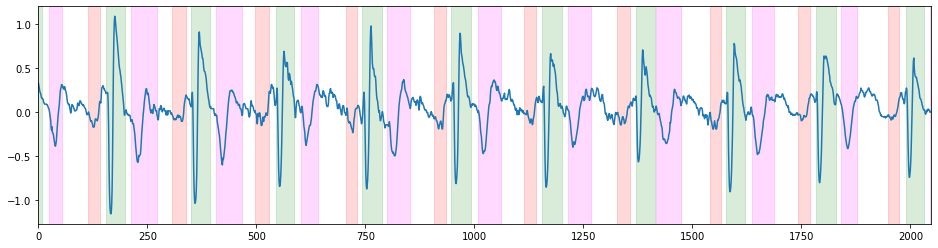

In [17]:
plt.figure(figsize=(16,4))
plt.plot(a.T)
ax = plt.gca()
pon,poff = sak.signal.get_mask_boundary(b[0,:])
qrson,qrsoff = sak.signal.get_mask_boundary(b[1,:])
ton,toff = sak.signal.get_mask_boundary(b[2,:])
[ax.axvspan(on,off,alpha=0.15,color='red') for on,off in zip(pon,poff)]
[ax.axvspan(on,off,alpha=0.15,color='green') for on,off in zip(qrson,qrsoff)]
[ax.axvspan(on,off,alpha=0.15,color='magenta') for on,off in zip(ton,toff)]
_=plt.xlim([0,2048])

In [ ]:
total = sum([(x[k].size - 2048 + 128)//128 for k in x])

for i in range(total):
    # Retrieve single window
    numRecord = int(i)//int(self.num_windows)
    key       = self.x.keys()[numRecord]
    n_window  = (int(i)-numRecord*self.num_windows)


In [ ]:
# Desambiguate data augmentation
j         = i//(self.num_windows*len(self.x))
i         = i%(self.num_windows*len(self.x))
numRecord = int(i)//int(self.num_windows)
key       = self.x.keys()[numRecord]
n_window  = (int(i)-numRecord*self.num_windows)


In [108]:
import skimage

In [119]:
x[k].shape

(1, 8968)

In [131]:
(x[k].size-2048+128)//128

55

In [192]:
import sak
import sak.torch
import sak.torch.data

In [223]:
dataset = sak.torch.data.UniformMultiDataset((dataset1,dataset2),draws=[5,1],weights=[0.2,1],return_weights=True)
sampler = sak.torch.data.UniformMultiSampler(dataset)
loader  = torch.utils.data.DataLoader(dataset,batch_size=128,sampler=sampler)

In [227]:
for x,y,w in loader:
    pass

In [179]:
import torch
from typing import Iterable, Union, List, Callable, Sized


class DatasetComposer(torch.utils.data.Dataset):
    '''Composer that draws samples from multiple dataset classes'''

    def __init__(self, datasets: Iterable[torch.utils.data.Dataset], 
                 draws: Union[Iterable,int] = 1, 
                 weights: Union[Iterable,int] = 1,
                 strategy: Union[Iterable,str] = "randint",
                 return_weights: bool = False,
                 shuffle: bool = True):
        # Datasets
        if isinstance(datasets, Iterable):
            self.datasets = datasets
        else:
            raise ValueError("'datasets' must be an iterable")

        # Draws
        if isinstance(draws, Iterable):
            assert len(datasets) == len(draws)
            assert all([d > 0 for d in draws])
            self.draws = draws
        elif isinstance(draws, int):
            self.draws = [draws for _ in self.datasets]
        else:
            raise ValueError("'draws' must be an iterable or a single int")

        # Weights
        if isinstance(weights, Iterable):
            assert len(datasets) == len(weights)
            self.weights = weights
        elif isinstance(weights, int):
            self.weights = [weights for _ in self.datasets]
        else:
            raise ValueError("'weights' must be an iterable or a single int")
        
        # Compute number of generable samples & iterations
        self.iterations = math.ceil(max([len(d)/self.draws[i] for i,d in enumerate(self.datasets)]))
        self.len = self.iterations*sum(self.draws)
        self.indices = [np.arange(len(d)) for d in self.datasets]
        self.__return_weights = return_weights

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        # Retrieve indices
        i,g = index

        # Retrieve dataset
        dataset = self.datasets[g]
        
        # If the index exceeds the number of elements, module
        i = i%len(dataset)
        
        # Define output
        out = dataset[i]
        if self.__return_weights: 
            out = (*out, self.weights[g])
        
        return i,g

    
class CustomSampler(torch.utils.data.Sampler):
    def __init__(self, data_source: Sized) -> None:
        self.data_source = data_source
        self.groups = [len(d) for d in self.data_source.datasets]
        self.iterations = data_source.iterations
        self.len = data_source.len

    @property
    def num_samples(self) -> int:
        # dataset size might change at runtime
        return sum(self.groups)

    def __iter__(self):
        # Iterate over dataset
        ordering = np.random.permutation(np.arange(len(self.data_source.datasets)))
        index_dataset = np.concatenate([[i]*(self.data_source.draws[i]) for i in ordering])
        index_dataset = np.tile(index_dataset,self.iterations)

        # Iterate over windows
        index_windows = np.zeros_like(index_dataset)
        for i,draw in enumerate(self.data_source.draws):
            num_indices = draw*self.iterations
            index_temp = [np.random.permutation(start+np.arange(self.groups[i])) for start in range(0,num_indices,self.groups[i])]
            index_windows[index_dataset == i] = np.concatenate(index_temp)[:num_indices]
        
        # Instantiate generator
        generator = torch.Generator()
        generator.manual_seed(int(torch.empty((), dtype=torch.int64).random_().item()))
        
        # Return iterable
        yield from zip(index_windows,index_dataset)

    def __len__(self):
        return sum(self.groups)



In [181]:
dataset = DatasetComposer([dataset1,dataset2], draws=[40,1], weights=[0.25,1], return_weights=True, strategy="module")
sampler = CustomSampler(dataset)
loader  = torch.utils.data.DataLoader(dataset,batch_size=128,sampler=sampler)

In [186]:
after = []
for i,out in enumerate(loader):
    after.append(out[0].numpy()[out[1].numpy() == 0])
after = np.concatenate(after)
out

[tensor([7975, 5977, 1474, 2313, 5935, 7094, 1975, 5864, 4239, 4590, 4029,  854,
          404, 4150,  286, 5296,   11, 1027, 5894, 5039, 3004,  989, 7379,  172,
         1949, 6374, 6605, 7827, 4613, 7011, 2211, 3268, 6308,  166]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1])]

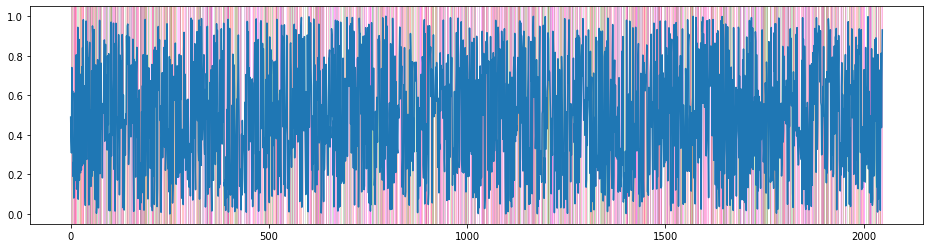

In [61]:
i = 6
sig = out[0][i,0,:]
seg = out[1][i,:,:].numpy()

pon,poff     = sak.signal.get_mask_boundary(seg[0,:])
qrson,qrsoff = sak.signal.get_mask_boundary(seg[1,:])
ton,toff     = sak.signal.get_mask_boundary(seg[2,:])

plt.figure(figsize=(16,4))
plt.plot(sig)
ax = plt.gca()
[ax.axvspan(on,off,color='red',alpha=0.15) for on,off in zip(pon,poff)]
[ax.axvspan(on,off,color='green',alpha=0.15) for on,off in zip(qrson,qrsoff)]
[ax.axvspan(on,off,color='magenta',alpha=0.15) for on,off in zip(ton,toff)]
plt.show()

In [748]:
sampler=CustomSampler(dataset)
index = []
for i,id in enumerate(sampler):
    index.append(id)
index = np.array(index)

In [752]:
np.unique(index[index[:,0] == 1,1])

array([   0,    1,    2, ..., 4032, 4033, 4034])

In [656]:
%%timeit
temp2()

2.24 µs ± 35.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [633]:
self = DatasetComposer([dataset1,dataset2], draws=[2,1], weights=[0.25,1], return_weights=True)

In [657]:
self[(0,1)]

(array([[0.4096097 , 0.63108205, 0.46630633, ..., 0.23114057, 0.89139371,
         0.55468477]]),
 array([[False, False, False, ...,  True,  True, False],
        [ True, False, False, ...,  True, False, False],
        [False,  True, False, ...,  True, False,  True]]),
 1)